In [1]:
"""
    All install libraries are mentioned in requirements.txt file
    please run !pip install -r requirements.txt to install all the libraries
"""
# !pip install dask
# !pip install dask[dataframe]
# !pip install vaderSentiment
# !pip install tensorflow[and-cuda]
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers
# !pip install datasets
# !pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
import dask.dataframe as dd
from scipy.sparse import hstack, csr_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from datasets import Dataset
import csv
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from bs4 import BeautifulSoup

C:\Users\mouli\Documents\BrightFlag\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
import torch

print(tf.__version__)
print(torch.__version__)

2.13.1
2.3.1+cu118


In [3]:
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [2]:
df = pd.read_csv("data/raw/amazon_reviews_us_Books_v1_02.tsv", sep='\t', on_bad_lines="skip")

In [3]:
df.head()

marketplace  customer_id       review_id  product_id  product_parent  \
0          US     12076615   RQ58W7SMO911M  0385730586       122662979   
1          US     12703090    RF6IUKMGL8SF  0811828964        56191234   
2          US     12257412  R1DOSHH6AI622S  1844161560       253182049   
3          US     50732546   RATOTLA3OF70O  0373836635       348672532   
4          US     51964897  R1TNWRKIVHVYOV  0262181533       598678717   

                                       product_title product_category  \
0         Sisterhood of the Traveling Pants (Book 1)            Books   
1      The Bad Girl's Guide to Getting What You Want            Books   
2             Eisenhorn (A Warhammer 40,000 Omnibus)            Books   
3                    Colby Conspiracy (Colby Agency)            Books   
4  The Psychology of Proof: Deductive Reasoning i...            Books   

   star_rating  helpful_votes  total_votes vine verified_purchase  \
0          4.0            2.0          3.0    N                 N   
1          3.0            5.0          5.0    N                 N   
2          4.0            1.0         22.0    N                 N   
3          5.0            2.0          2.0    N                 N   
4          4.0            0.0          2.0    N                 N   

                         review_headline  \
0  this book was a great learning novel!   
1                              Fun Fluff   
2                    this isn't a review   
3              fine author on her A-game   
4          Execellent cursor examination   

                                         review_body review_date  
0  this boook was a great one that you could lear...  2005-10-14  
1  If you are looking for something to stimulate ...  2005-10-14  
2  never read it-a young relative idicated he lik...  2005-10-14  
3  Though she is honored to be Chicago Woman of t...  2005-10-14  
4  Review based on a cursory examination by Unive...  2005-10-14

### marketplace
    - 2 letter country code of the marketplace where the review was written.
### customer_id
    - Random identifier that can be used to aggregate reviews written by a single author.
### review_id
    - The unique ID of the review.
### product_id
    - The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id.
### product_parent
    - Random identifier that can be used to aggregate reviews for the same product.
### product_title
    - Title of the product.
### product_category
    - Broad product category that can be used to group reviews (also used to group the dataset into coherent parts).
### star_rating
    - The 1-5 star rating of the review.
### helpful_votes
    - Number of helpful votes.
### total_votes
    - Number of total votes the review received.
### vine
    - Review was written as part of the Vine program.
### verified_purchase
    - The review is on a verified purchase.
### review_headline
    - The title of the review.
### review_body
    - The review text.
### review_date
    -The date the review was written.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105370 entries, 0 to 3105369
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 355.4+ MB


In [5]:
df.shape

(3105370, 15)

# Exploratory Data Analysis 

In [6]:
# Checking for null values
df.isna().sum()

marketplace            0
customer_id            0
review_id              0
product_id             0
product_parent         0
product_title          0
product_category       0
star_rating            4
helpful_votes          4
total_votes            4
vine                   4
verified_purchase      4
review_headline       57
review_body            4
review_date          133
dtype: int64

In [7]:
# Checking for duplicates
duplicates = df.duplicated().sum()
print(f'Duplicates: {duplicates}')

Duplicates: 0


In [24]:
# Product reviews by country
count_cat = df.groupby('marketplace')['marketplace'].count()
print(count_cat)
# We have reviews only from US


marketplace
US    3105370
Name: marketplace, dtype: int64


In [10]:
# Product reviews by product_category
prod_cat = df.groupby('product_category')['product_category'].count()
print(prod_cat)
print(df['product_category'].unique())

# dropping rows with invalid product categories as we got 4 rows with dates as product categories.
df =df[df['product_category'] == 'Books']
print(df['product_category'].unique())

product_category
2000-11-06          1
2002-08-07          1
2003-02-05          1
2005-03-11          1
Books         3105366
Name: product_category, dtype: int64
['Books' '2005-03-11' '2003-02-05' '2002-08-07' '2000-11-06']
['Books']


In [11]:
# Product reviews by product_parent
prodp_cat = df.groupby('product_parent')['product_parent'].count()
print(prodp_cat)
print("------------------------------")
print("Product reviews by top 100 product_parent")
print(df.groupby('product_parent')['product_parent'].count().nlargest(100))

product_parent
689           7
3474          5
3571          1
6395          1
6430         26
             ..
999993855    26
999993974    14
999997462     1
999998992     1
999999938     1
Name: product_parent, Length: 666016, dtype: int64
------------------------------
Product reviews by top 100 product_parent
product_parent
667539744    15925
669379389     3815
315416156     3221
857217799     2785
829131114     2619
             ...  
442293804      711
706464487      709
502818647      706
939508171      697
723611342      694
Name: product_parent, Length: 100, dtype: int64


In [12]:
# Product reviews by product_title
prodT_cat = df.groupby('product_title')['review_id'].count().nlargest(100)
print(prodT_cat)
print("------------------------------")

product_title
Harry Potter and the Order of the Phoenix (Book 5)                     4862
Harry Potter And The Goblet Of Fire (Book 4)                           3740
The Da Vinci Code                                                      2706
Lies and the Lying Liars Who Tell Them                                 2665
Unfit For Command: Swift Boat Veterans Speak Out Against John Kerry    2615
                                                                       ... 
Living History                                                          621
She's Come Undone (Oprah's Book Club)                                   618
Confessions of a Shopaholic (Shopaholic, No 1)                          615
Michael Moore Is a Big Fat Stupid White Man                             615
Of Mice and Men                                                         613
Name: review_id, Length: 100, dtype: int64
------------------------------


In [14]:
df[df['product_title'] == 'Harry Potter and the Order of the Phoenix (Book 5)']

marketplace  customer_id       review_id  product_id  product_parent  \
8392             US     29177055  R31VCC2641GNKT  0807220299       667539744   
11402            US     26985540  R2O1NJ8SPXXL72  043935806X       667539744   
11879            US     26985540  R1T4L1KD4NT42E  043935806X       667539744   
14474            US     15328501  R2NBD0OJUQT1JG  043935806X       667539744   
14882            US     31563574   RIOORKJRLT553  043935806X       667539744   
...             ...          ...             ...         ...             ...   
1080220          US     42060684   RCLGMCPT6BXTD  043935806X       667539744   
1080223          US     29599442  R2KPECD12UN6LU  043935806X       667539744   
1080224          US     30514364   REG9ZXPDO2U8X  043935806X       667539744   
1080226          US     50198498  R33SPYUIR06LX2  043935806X       667539744   
1080239          US     29617247  R3Q4KC7VF525PT  0807220299       667539744   

                                             product_title product_category  \
8392     Harry Potter and the Order of the Phoenix (Boo...            Books   
11402    Harry Potter and the Order of the Phoenix (Boo...            Books   
11879    Harry Potter and the Order of the Phoenix (Boo...            Books   
14474    Harry Potter and the Order of the Phoenix (Boo...            Books   
14882    Harry Potter and the Order of the Phoenix (Boo...            Books   
...                                                    ...              ...   
1080220  Harry Potter and the Order of the Phoenix (Boo...            Books   
1080223  Harry Potter and the Order of the Phoenix (Boo...            Books   
1080224  Harry Potter and the Order of the Phoenix (Boo...            Books   
1080226  Harry Potter and the Order of the Phoenix (Boo...            Books   
1080239  Harry Potter and the Order of the Phoenix (Boo...            Books   

         star_rating  helpful_votes  total_votes vine verified_purchase  \
8392             5.0            1.0          1.0    N                 N   
11402            5.0            0.0          0.0    N                 N   
11879            5.0            0.0          0.0    N                 N   
14474            5.0            1.0          3.0    N                 N   
14882            4.0            1.0          1.0    N                 Y   
...              ...            ...          ...  ...               ...   
1080220          3.0            2.0          4.0    N                 N   
1080223          4.0            0.0          0.0    N                 N   
1080224          5.0            0.0          1.0    N                 N   
1080226          5.0            3.0          3.0    N                 N   
1080239          5.0            1.0          2.0    N                 N   

                                           review_headline  \
8392     Harry Potter and the Order of the Phoenix (Boo...   
11402    Harry rescues the wizarding world again as vol...   
11879    Harry rescues the wizarding world again as vol...   
14474                                  Harry Potter book 5   
14882                                          Even better   
...                                                    ...   
1080220  Not up to JKR's usual standard-but it is still...   
1080223            Exciting and Intriguing New Installment   
1080224                                              Great   
1080226                                          fantastic   
1080239                 Excellence in childrens literature   

                                               review_body review_date  
8392     It is so much fun to drive in commuter trafic ...  2005-10-09  
11402    the fifth of seven of the most magical amazing...  2005-10-07  
11879    the fifth of seven of the most magical amazing...  2005-10-07  
14474    I received the book in excellent condition and...  2005-10-05  
14882    I can't wait for the next one now!  The plot i...  2005-10-05  
...           

In [25]:
# Avg star rating for each product_parent
avg_rating = df.groupby('product_parent')['star_rating'].mean()
print("avg star rating for each product parent:", avg_rating.nlargest(100))

avg star rating for each product parent: product_parent
3474      5.0
3571      5.0
6395      5.0
10405     5.0
10916     5.0
         ... 
344540    5.0
344928    5.0
360248    5.0
361647    5.0
364161    5.0
Name: star_rating, Length: 100, dtype: float64


In [26]:
# total_votes per product_parent
total_votes = df.groupby('product_parent')['total_votes'].sum().nlargest(100)

print("Total_votes for each  product_parent: ", total_votes)

Total_votes for each  product_parent:  product_parent
829131114    130665.0
857217799     69402.0
667539744     50224.0
820650568     49053.0
315416156     44345.0
               ...   
466544708     10161.0
648927278     10106.0
862964341     10105.0
492085239     10057.0
904288157     10037.0
Name: total_votes, Length: 100, dtype: float64


In [27]:
# helpful_votes for each product_parent
helpful_votes = df.groupby('product_parent')['helpful_votes'].sum()

print("helpful_votes for each  product_parent: ", helpful_votes.nlargest(100))

helpful_votes for each  product_parent:  product_parent
829131114    75871.0
857217799    31819.0
156348512    30445.0
667539744    28917.0
845551770    26082.0
              ...   
984149518     6923.0
766400438     6921.0
799606467     6854.0
806338654     6825.0
171804759     6745.0
Name: helpful_votes, Length: 100, dtype: float64


In [18]:
# calculating helpfulness for each product_parent 
helpful_votes = helpful_votes.reindex(total_votes.index)
ratio = np.where(total_votes == 0, 0, helpful_votes / total_votes)

pd.DataFrame({
    'product_parent': helpful_votes.index,
    'helpful_votes': helpful_votes.values,
    'total_votes': total_votes.values,
    'helpful_ratio': ratio
})

product_parent  helpful_votes  total_votes  helpful_ratio
0                  689          137.0        170.0       0.805882
1                 3474           31.0         41.0       0.756098
2                 3571            4.0          4.0       1.000000
3                 6395            0.0          0.0       0.000000
4                 6430          145.0        202.0       0.717822
...                ...            ...          ...            ...
666011       999993855          224.0        332.0       0.674699
666012       999993974          204.0        306.0       0.666667
666013       999997462           16.0         16.0       1.000000
666014       999998992            0.0          4.0       0.000000
666015       999999938            2.0          8.0       0.250000

[666016 rows x 4 columns]

In [19]:
# calculating helpful_votes, total_votes and helpfulness values for each product_id
total_votes_prod = df.groupby('product_id')['total_votes'].sum()
helpful_votes_prod = df.groupby('product_id')['helpful_votes'].sum()

helpful_votes_prod = helpful_votes_prod.reindex(total_votes_prod.index)
ratio_prod = np.where(total_votes_prod == 0, 0, helpful_votes_prod / total_votes_prod)

pd.DataFrame({
    'product_id': helpful_votes_prod.index,
    'helpful_votes': helpful_votes_prod.values,
    'total_votes': total_votes_prod.values,
    'helpful_ratio': ratio_prod
})

product_id  helpful_votes  total_votes  helpful_ratio
0       0000000078            1.0          3.0       0.333333
1       0000000116            5.0          5.0       1.000000
2       0000000868           10.0         10.0       1.000000
3       0000020214            1.0          3.0       0.333333
4       0000024341            8.0          8.0       1.000000
...            ...            ...          ...            ...
779705  B003NHR7GC            2.0          2.0       1.000000
779706  B00731BVMU            0.0          0.0       0.000000
779707  B0083TTJPC            0.0          0.0       0.000000
779708  B008GPOJ1C            0.0          0.0       0.000000
779709  B008W3IU6I            2.0          2.0       1.000000

[779710 rows x 4 columns]

In [28]:
# calculating helpful_votes, total_votes and helpfulness values for each review
total_votes_id = df.groupby('product_id')['total_votes'].sum()
helpful_votes_id = df.groupby('product_id')['helpful_votes'].sum()

helpful_votes_id = helpful_votes_id.reindex(total_votes_id.index)
ratio_id = np.where(total_votes_id == 0, 0, helpful_votes_id / total_votes_id)

review_helpfulness = pd.DataFrame({
    'product_id': helpful_votes_id.index,
    'helpful_votes': helpful_votes_id.values,
    'total_votes': total_votes_id.values,
    'helpful_ratio': ratio_id
})

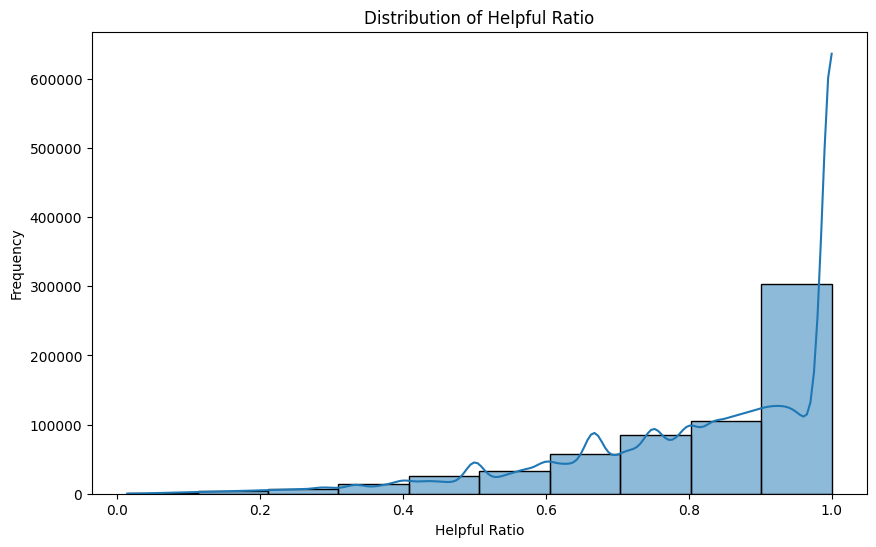

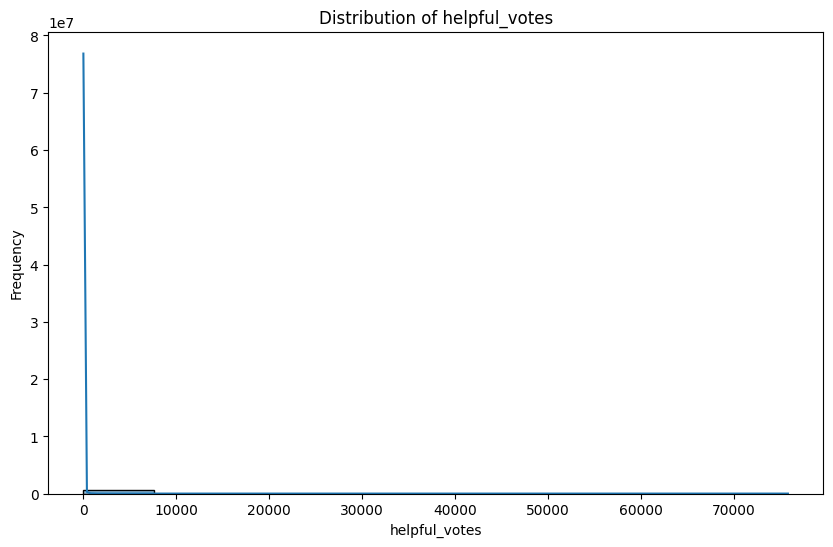

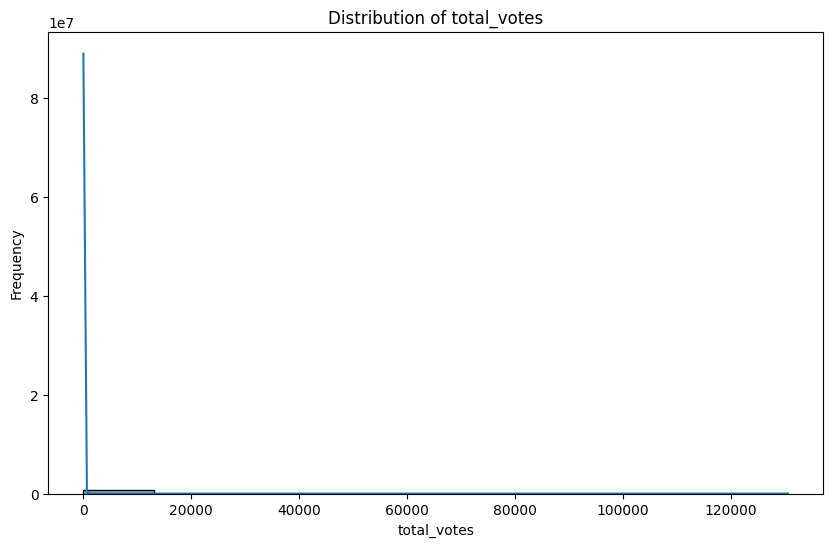

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(review_helpfulness[(review_helpfulness["helpful_votes"] >1) & (review_helpfulness["total_votes"] >1)]['helpful_ratio'], bins=10, kde=True)
plt.title('Distribution of Helpful Ratio')
plt.xlabel('Helpful Ratio')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(review_helpfulness[(review_helpfulness["helpful_votes"] >1) & (review_helpfulness["total_votes"] >1)]['helpful_votes'], bins=10, kde=True)
plt.title('Distribution of helpful_votes')
plt.xlabel('helpful_votes')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(review_helpfulness[(review_helpfulness["helpful_votes"] >1) & (review_helpfulness["total_votes"] >1)]['total_votes'], bins=10, kde=True)
plt.title('Distribution of total_votes')
plt.xlabel('total_votes')
plt.ylabel('Frequency')
plt.show()

# Univariate Analysis


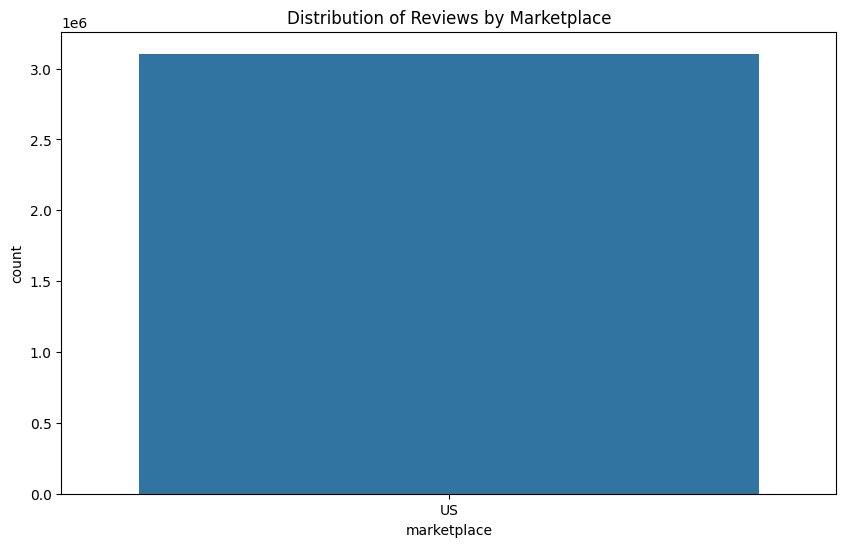

In [30]:
# Categorical Variables
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='marketplace')
plt.title('Distribution of Reviews by Marketplace')
plt.show()

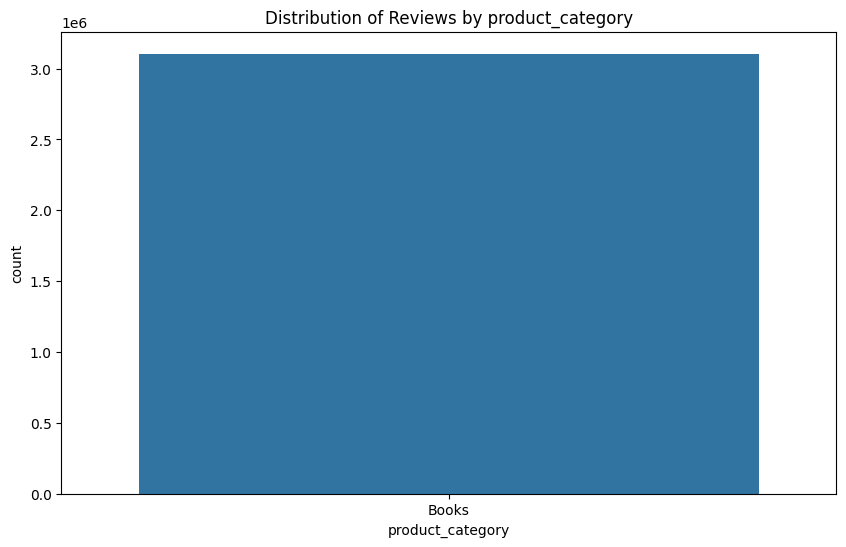

In [31]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='product_category')
plt.title('Distribution of Reviews by product_category')
plt.show()

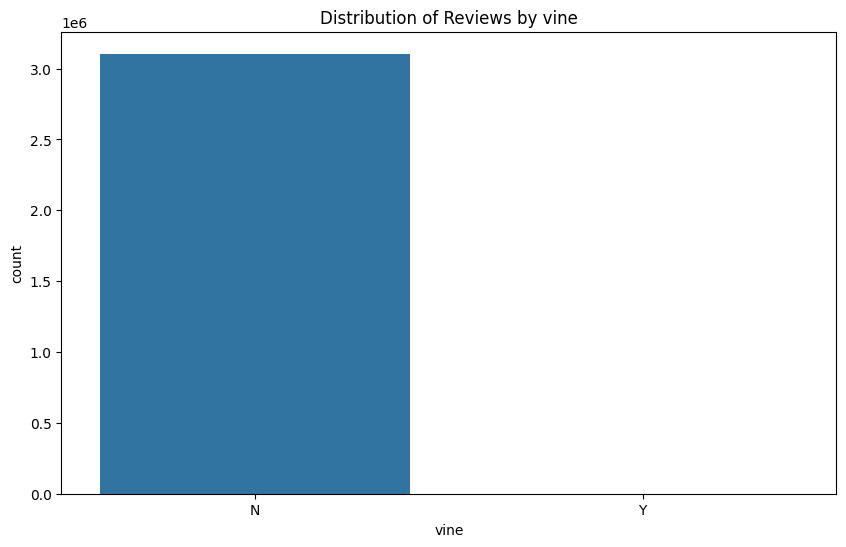

In [33]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='vine')
plt.title('Distribution of Reviews by vine')
plt.show()

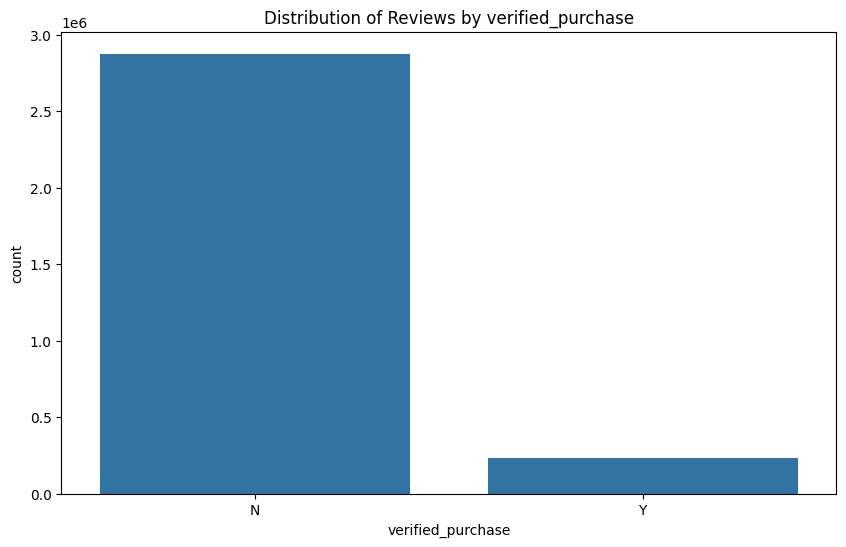

In [34]:

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='verified_purchase')
plt.title('Distribution of Reviews by verified_purchase')
plt.show()

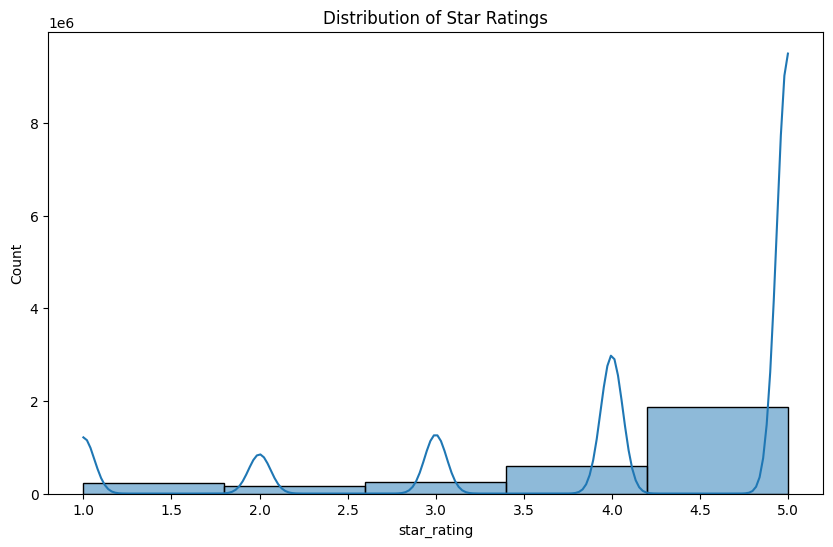

In [35]:
# Numerical Variables
plt.figure(figsize=(10, 6))
sns.histplot(df['star_rating'], bins=5, kde=True)
plt.title('Distribution of Star Ratings')
plt.show()

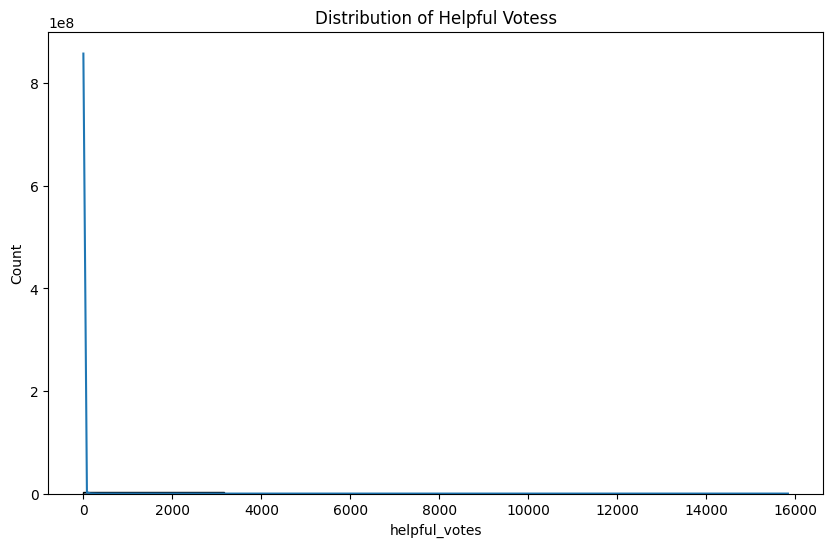

In [36]:

plt.figure(figsize=(10, 6))
sns.histplot(df['helpful_votes'], bins=5, kde=True)
plt.title('Distribution of Helpful Votess')
plt.show()

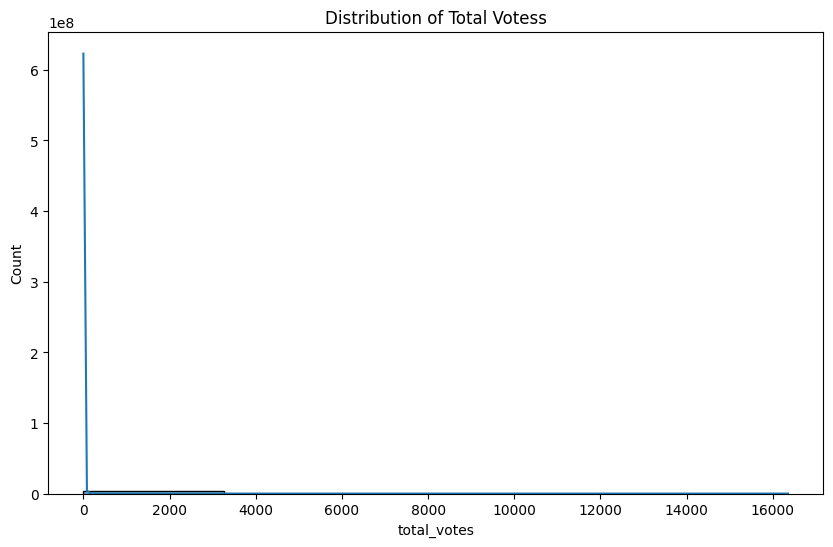

In [37]:

plt.figure(figsize=(10, 6))
sns.histplot(df['total_votes'], bins=5, kde=True)
plt.title('Distribution of Total Votess')
plt.show()

 # Bivariate Analysis

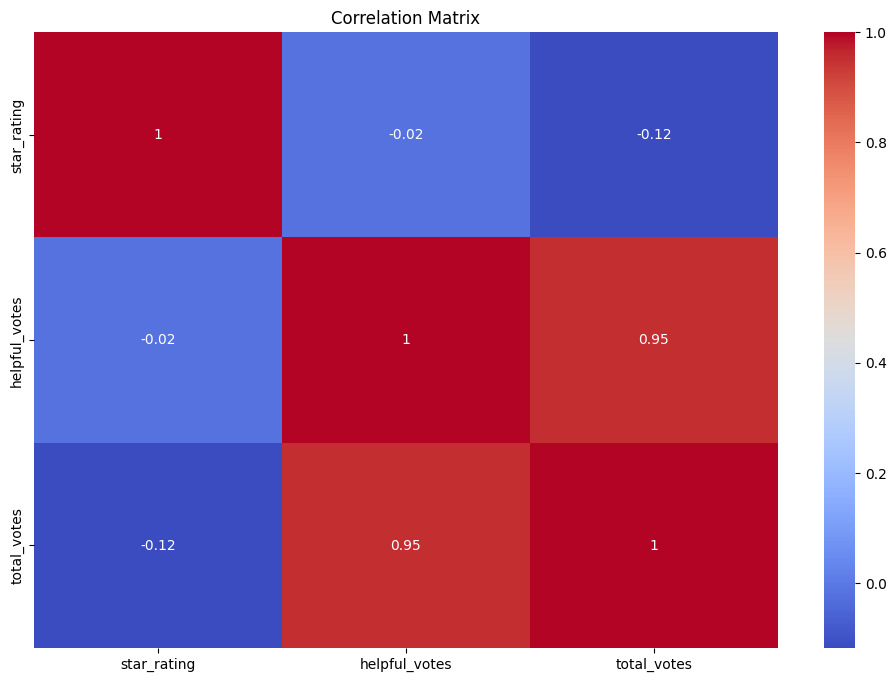

In [39]:
correlation_matrix = df[["star_rating","helpful_votes","total_votes"]].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

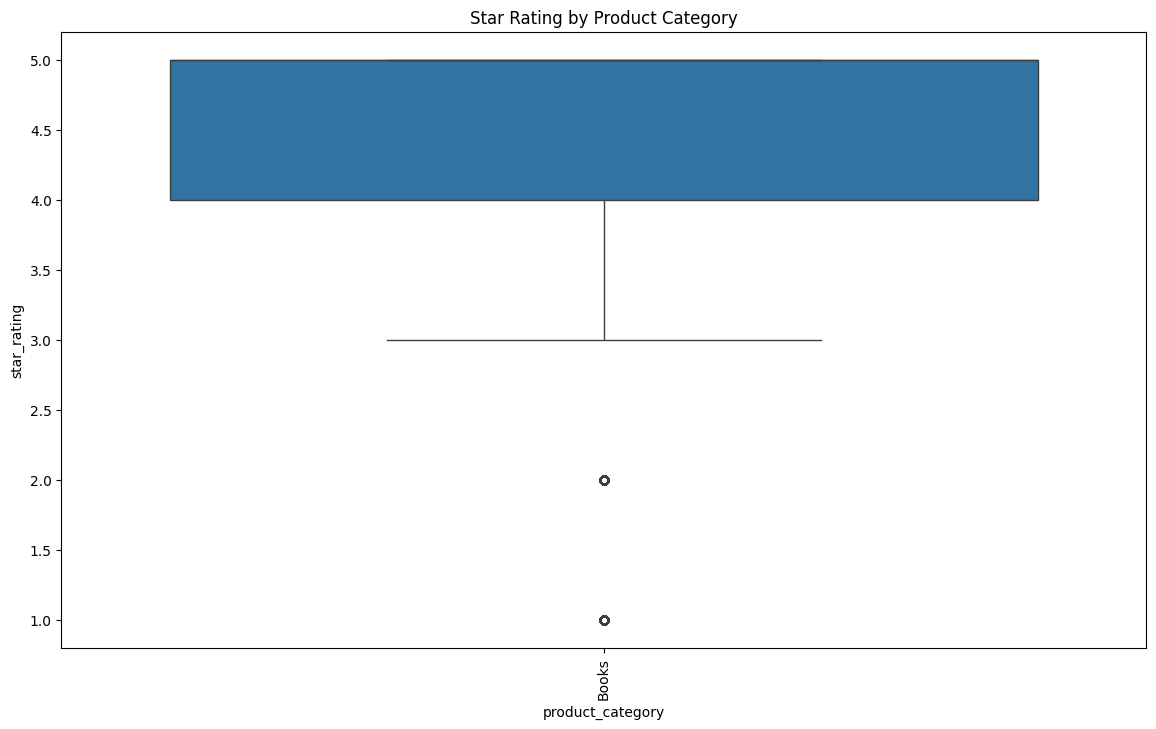

In [40]:
# Star Rating vs Product Category
plt.figure(figsize=(14, 8))
sns.boxplot(data=df, x='product_category', y='star_rating')
plt.xticks(rotation=90)
plt.title('Star Rating by Product Category')
plt.show()

# Time Series Analysis

C:\Users\mouli\AppData\Local\Temp\ipykernel_15512\2308040110.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_reviews = df.resample('M').count()


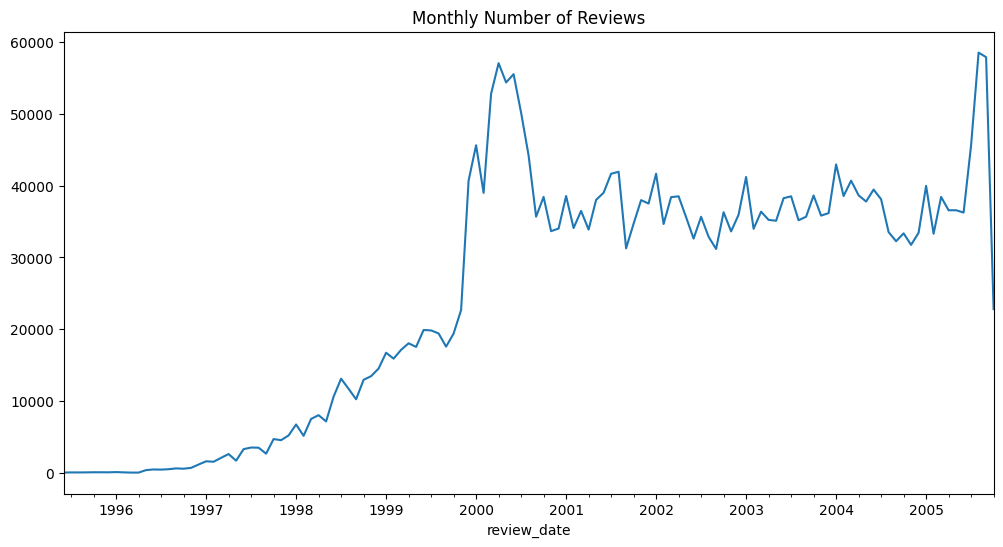

In [41]:
df['review_date'] = pd.to_datetime(df['review_date'])
df.set_index('review_date', inplace=True)
monthly_reviews = df.resample('M').count()
plt.figure(figsize=(12, 6))
monthly_reviews['review_id'].plot()
plt.title('Monthly Number of Reviews')
plt.show()

# Sentiment Analysis

In [49]:
# Data type conversions
df['star_rating'] = df['star_rating'].astype(int)
df['helpful_votes'] = df['helpful_votes'].astype(int)
df['total_votes'] = df['total_votes'].astype(int)
df['vine'] = df['vine'].astype('category')
df['verified_purchase'] = df['verified_purchase'].astype('category')
df['marketplace'] = df['marketplace'].astype('category')
df['product_category'] = df['product_category'].astype('category')
df['review_id'] = df['review_id'].astype(str)
df['product_id'] = df['product_id'].astype(str)
df['product_title'] = df['product_title'].astype(str)
df['review_headline'] = df['review_headline'].astype(str)
df['review_body'] = df['review_body'].astype(str)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3105366 entries, 2005-10-14 to 1995-06-24
Data columns (total 14 columns):
 #   Column             Dtype   
---  ------             -----   
 0   marketplace        category
 1   customer_id        int64   
 2   review_id          object  
 3   product_id         object  
 4   product_parent     int64   
 5   product_title      object  
 6   product_category   category
 7   star_rating        int32   
 8   helpful_votes      int32   
 9   total_votes        int32   
 10  vine               category
 11  verified_purchase  category
 12  review_headline    object  
 13  review_body        object  
dtypes: category(4), int32(3), int64(2), object(5)
memory usage: 236.9+ MB


In [51]:
analyzer = SentimentIntensityAnalyzer()
"""
    The below function calculates the sentiment of the text using Vader 
"""
def get_sentiment_score(review_body):
    return analyzer.polarity_scores(review_body)['compound']


In [52]:
df['sentiment_score'] = df['review_body'].apply(get_sentiment_score)

In [73]:
print(df[['review_body', 'sentiment_score']][3:4].iloc[0,0] )
print(df[['review_body', 'sentiment_score']][3:4].iloc[0,1] )

Though she is honored to be Chicago Woman of the Year, Victoria Colby-Camp is more euphoric over the mental improvement that her son Jim has shown recently especially since he and Tasha North fell in love.  Jim was snatched almost twenty years ago when he was seven and turned into the killing Seth whose goal was to murder Victoria for abandoning him.  However, her elation would turn to despair if she knew Seth resurfaced and started to rape a pregnant Tasha.<br /><br />Former military strategist Daniel Marks is in town complements of the Colby Agency that wants to hire him.  Also in Chicago is Emily Hastings whose father a veteran homicide detective was murdered.  She finds letters linking her dad to Victoria, the woman's long ago murdered first husband James, and her dad's first partner Marelyn Rutland that confuses her.  Soon she will meet Daniel and they will be embroiled in the COLBY CONSPIRACY that goes back almost two decades ago.<br /><br />Though the subplots can become confusi

In [54]:
# Correlation Analysis
correlation_matrix = df[['sentiment_score', 'helpful_votes', 'total_votes']].corr()

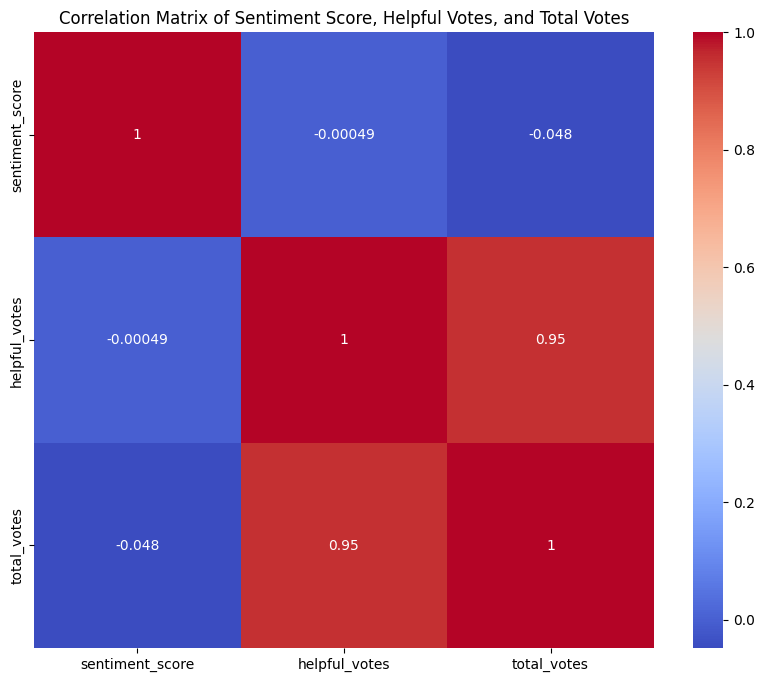

In [55]:
# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Sentiment Score, Helpful Votes, and Total Votes')
plt.show()

C:\Users\mouli\Documents\BrightFlag\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


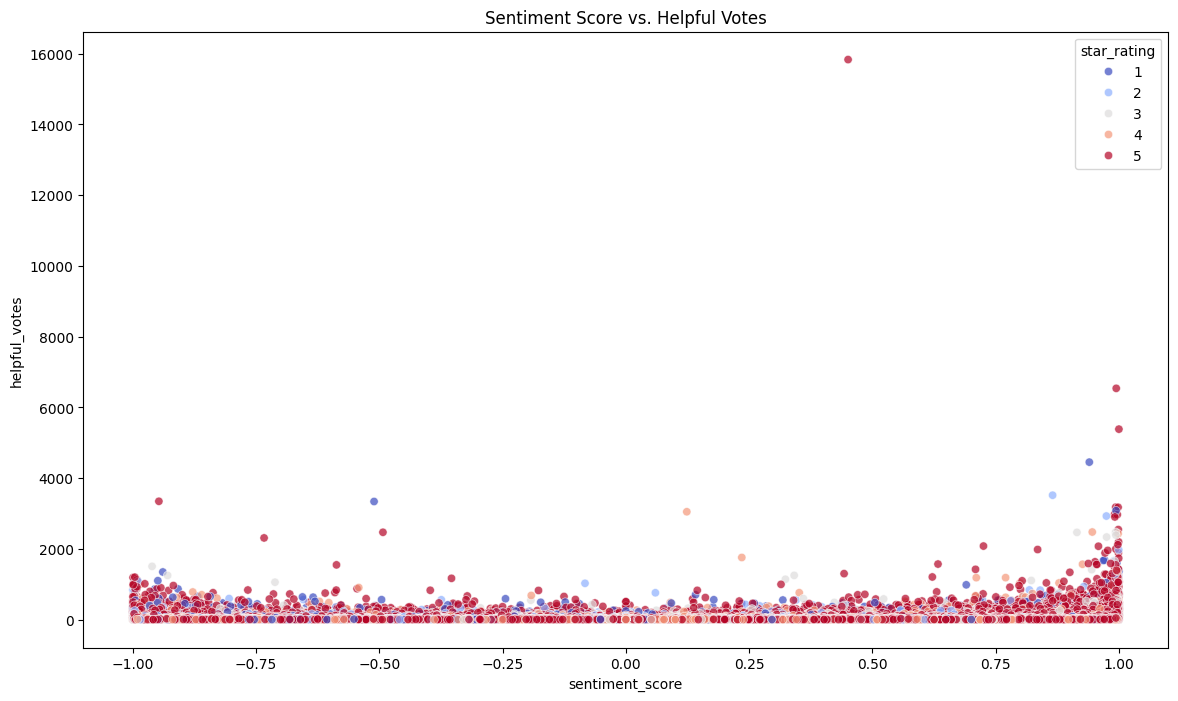

In [56]:
# Scatter plot to visualize the relationship
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='sentiment_score', y='helpful_votes', hue='star_rating', palette='coolwarm', alpha=0.7)
plt.title('Sentiment Score vs. Helpful Votes')
plt.show()

C:\Users\mouli\Documents\BrightFlag\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


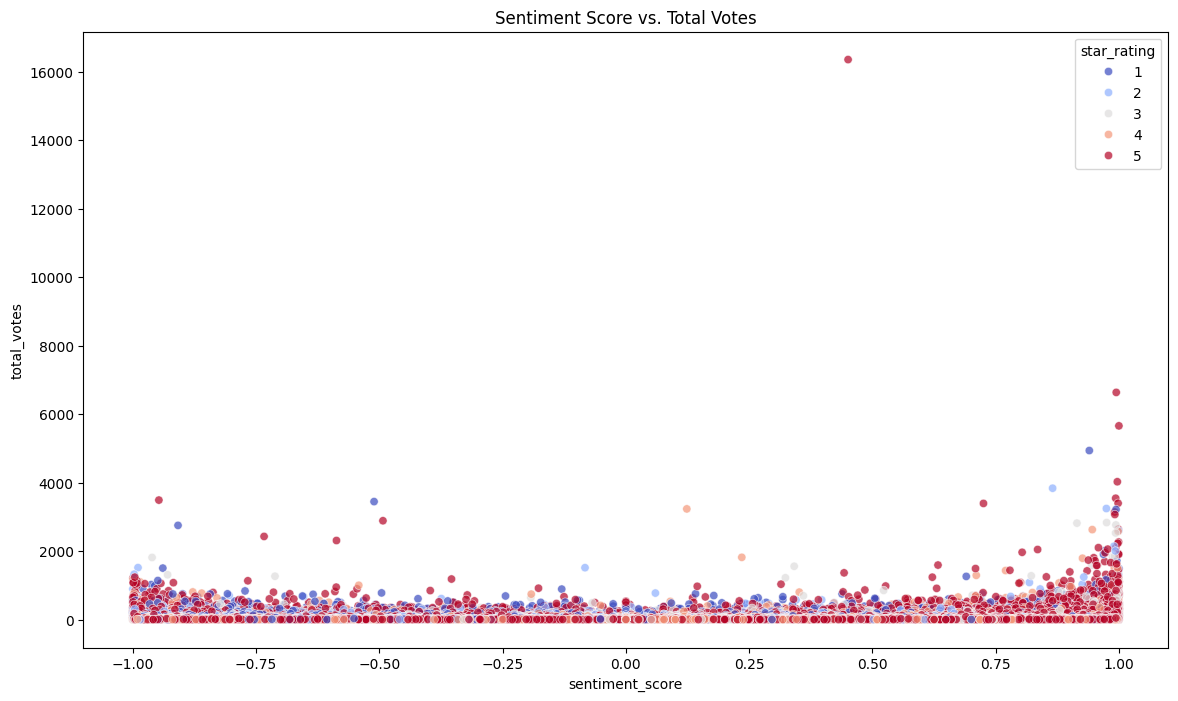

In [57]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df, x='sentiment_score', y='total_votes', hue='star_rating', palette='coolwarm', alpha=0.7)
plt.title('Sentiment Score vs. Total Votes')
plt.show()

# Interpretation
<B>From the the above graph we can see a mix of high and low-star rating reviews spread across the sentiment spectrum. 
This indicates that the sentiment of the reviews is not highly correlated with the helpful_ness ratio or any votes. 

Take review below, in general, it is a positive review. Yet it got a -0.93 sentiment score.

The reason for this is the usage of strong negative phrases in the review which influenced the sentiment score.<B>

In [77]:
print(df[['review_body', 'sentiment_score']][3:4].iloc[0,0] )
print(df[['review_body', 'sentiment_score']][3:4].iloc[0,1] )

Though she is honored to be Chicago Woman of the Year, Victoria Colby-Camp is more euphoric over the mental improvement that her son Jim has shown recently especially since he and Tasha North fell in love.  Jim was snatched almost twenty years ago when he was seven and turned into the killing Seth whose goal was to murder Victoria for abandoning him.  However, her elation would turn to despair if she knew Seth resurfaced and started to rape a pregnant Tasha.<br /><br />Former military strategist Daniel Marks is in town complements of the Colby Agency that wants to hire him.  Also in Chicago is Emily Hastings whose father a veteran homicide detective was murdered.  She finds letters linking her dad to Victoria, the woman's long ago murdered first husband James, and her dad's first partner Marelyn Rutland that confuses her.  Soon she will meet Daniel and they will be embroiled in the COLBY CONSPIRACY that goes back almost two decades ago.<br /><br />Though the subplots can become confusi

In [19]:
df.to_csv("data/EDA/reviews_with_sentiment_vader.csv")

NameError: name 'df' is not defined

## Work around

Get transformers sentiment score

In [20]:
df = pd.read_csv("data/EDA/reviews_with_sentiment_vader.csv")

In [21]:
sentiment_model = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)
sentiment_model("""Though she is honored to be Chicago Woman of the Year, Victoria Colby-Camp is more euphoric over the mental improvement that her son Jim has shown recently especially since he and Tasha North fell in love.  Jim was snatched almost twenty years ago when he was seven and turned into the killing Seth whose goal was to murder Victoria for abandoning him.  However, her elation would turn to despair if she knew Seth resurfaced and started to rape a pregnant Tasha.<br /><br />Former military strategist Daniel Marks is in town complements of the Colby Agency that wants to hire him.  Also in Chicago is Emily Hastings whose father a veteran homicide detective was murdered.  She finds letters linking her dad to Victoria, the woman's long ago murdered first husband James, and her dad's first partner Marelyn Rutland that confuses her.  Soon she will meet Daniel and they will be embroiled in the COLBY CONSPIRACY that goes back almost two decades ago.<br /><br />Though the subplots can become confusing at first, once the audience comprehends how this complex superb suspense thriller starts to come together, they will want more Colby Agency tales; (see FILES FROM THE COLBY AGENCY: THE BODYGUARD'S BABY PROTECTIVE CUSTODY).  The ensemble cast is solid as fans will feel with Victoria who has overcome so much tragedy, hope Jim \\"defeats\\" Seth with Tasha at his side, and root for Daniel and Emily to make it while wondering what really happened two decades ago.  A final twist marks a strong Webb of deceit tale that showcases a fine author on her A-game.<br /><br />Harriet Klausner""")[0]

{'label': 'POSITIVE', 'score': 0.9982919096946716}

In [59]:
"""
    To get sentiment score from transformer-based models I used distilbert-base-uncased-finetuned-sst-2-english

    Reasons for choosing this model:
        - This model is specifically fine-tunned for sentiment analysis
        - Smaller version of BERT
        - Computationally inexpensive
        - Fast inference (60% faster than BERT) 
        - Retains 97% of BERT language understanding capabilities
        - Accuracy is very close to BERT
        
"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')


# Initialize sentiment analysis pipeline with GPU support
sentiment_model = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)

"""
    This function both tokenizes and truncates the text.
"""
def preprocess_function(text):
    encoded_input = tokenizer(text, truncation=True, max_length=510)
    return encoded_input

"""
    This function takes each text, tokenizes it by calling preprocess_function and gets a sentiment score
"""
def get_sentiment_score(texts):
    results = []
    for text in texts:
        encoded_input = preprocess_function(text)
        result = sentiment_model(tokenizer.decode(encoded_input['input_ids']))[0]  # Get the first result
        score = result['score'] if result['label'] == 'POSITIVE' else -result['score']
        results.append(score)
    return results

# Process the data in chunks and write to CSV
input_file = 'data/EDA/reviews_with_sentiment_vader.csv'
output_file = 'data/EDA/reviews_with_sentiment_transformer.csv'
chunk_size = 50000

# Prepare the output file with the header
header = ['review_date', 'marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'sentiment_score','transformer_sentiment_score']
with open(output_file, 'w', newline='', encoding='utf-8') as f_out:
    writer = csv.writer(f_out)
    writer.writerow(header)

# Process the dataset in chunks
i = 0
for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    print("processing batch: ", i)
    # Data type conversions
    chunk['star_rating'] = chunk['star_rating'].astype(int)
    chunk['helpful_votes'] = chunk['helpful_votes'].astype(int)
    chunk['total_votes'] = chunk['total_votes'].astype(int)
    chunk['review_date'] = pd.to_datetime(chunk['review_date'])
    chunk['vine'] = chunk['vine'].astype('category')
    chunk['verified_purchase'] = chunk['verified_purchase'].astype('category')
    chunk['marketplace'] = chunk['marketplace'].astype('category')
    chunk['product_category'] = chunk['product_category'].astype('category')

    # Apply sentiment analysis
    chunk['transformer_sentiment_score'] = get_sentiment_score(chunk['review_body'].tolist())

    # save the processed chunk to the output file
    chunk.to_csv(output_file, mode='a', header=False, index=False, encoding='utf-8')
    i+=1


df_with_sentiment = pd.read_csv(output_file)


correlation_matrix = df_with_sentiment[['transformer_sentiment_score', 'helpful_votes', 'total_votes']].corr()



processing batch:  0
processing batch:  1
processing batch:  2
processing batch:  3
processing batch:  4
processing batch:  5
processing batch:  6
processing batch:  7
processing batch:  8
processing batch:  9
processing batch:  10
processing batch:  11
processing batch:  12
processing batch:  13
processing batch:  14
processing batch:  15
processing batch:  16
processing batch:  17
processing batch:  18
processing batch:  19
processing batch:  20
processing batch:  21
processing batch:  22
processing batch:  23
processing batch:  24
processing batch:  25
processing batch:  26
processing batch:  27
processing batch:  28
processing batch:  29
processing batch:  30
processing batch:  31
processing batch:  32
processing batch:  33
processing batch:  34
processing batch:  35
processing batch:  36
processing batch:  37
processing batch:  38
processing batch:  39
processing batch:  40
processing batch:  41
processing batch:  42
processing batch:  43
processing batch:  44
processing batch:  4

In [60]:
del df

In [43]:
df = pd.read_csv( 'data/EDA/reviews_with_sentiment_transformer.csv')

In [7]:
df.head()

review_date marketplace  customer_id       review_id  product_id  \
0  2005-10-14          US     12076615   RQ58W7SMO911M  0385730586   
1  2005-10-14          US     12703090    RF6IUKMGL8SF  0811828964   
2  2005-10-14          US     12257412  R1DOSHH6AI622S  1844161560   
3  2005-10-14          US     50732546   RATOTLA3OF70O  0373836635   
4  2005-10-14          US     51964897  R1TNWRKIVHVYOV  0262181533   

   product_parent                                      product_title  \
0       122662979         Sisterhood of the Traveling Pants (Book 1)   
1        56191234      The Bad Girl's Guide to Getting What You Want   
2       253182049             Eisenhorn (A Warhammer 40,000 Omnibus)   
3       348672532                    Colby Conspiracy (Colby Agency)   
4       598678717  The Psychology of Proof: Deductive Reasoning i...   

  product_category  star_rating  helpful_votes  total_votes vine  \
0            Books            4              2            3    N   
1            Books            3              5            5    N   
2            Books            4              1           22    N   
3            Books            5              2            2    N   
4            Books            4              0            2    N   

  verified_purchase                        review_headline  \
0                 N  this book was a great learning novel!   
1                 N                              Fun Fluff   
2                 N                    this isn't a review   
3                 N              fine author on her A-game   
4                 N          Execellent cursor examination   

                                         review_body  sentiment_score  \
0  this boook was a great one that you could lear...           0.9864   
1  If you are looking for something to stimulate ...           0.9393   
2  never read it-a young relative idicated he lik...           0.4215   
3  Though she is honored to be Chicago Woman of t...          -0.9343   
4  Review based on a cursory examination by Unive...           0.9231   

   transformer_sentiment_score  
0                     0.927252  
1                     0.999744  
2                    -0.976145  
3                     0.998236  
4                     0.999542

In [44]:
df[(df['star_rating']<=3) & (df["transformer_sentiment_score"]>0)][]

review_date marketplace  customer_id       review_id  product_id  \
1        2005-10-14          US     12703090    RF6IUKMGL8SF  0811828964   
45       2005-10-14          US     51303136  R13JG2D3U3OGQT  1594200459   
79       2005-10-14          US     16571810  R17VJ32BI1ECQL  3540236058   
83       2005-10-14          US     12069570   RYAKOMK44DE58  0446673544   
93       2005-10-14          US     24104879   RDBVYHGTTICMV  0307283658   
...             ...         ...          ...             ...         ...   
3105187  1995-12-14          US     53004137  R2I1MFWQFWU9IU  0385315023   
3105199  1995-12-10          US     53095549  R229AWY2SKEWC7  0393307328   
3105208  1995-11-28          US     53095692  R3PUU7Z35CKFFW  0786861592   
3105233  1995-11-13          US     53095776  R3JNYVZLP1APW5  0405038437   
3105283  1995-10-15          US     53096582  R3J35IE4LMNCOU  0465001041   

         product_parent                                      product_title  \
1              56191234      The Bad Girl's Guide to Getting What You Want   
45            697870179  The End of Poverty: Economic Possibilities for...   
79            855041492        Essential NMR: for Scientists and Engineers   
83            656995955                                   Sex and the City   
93            162568542    Harry Potter and the Half-Blood Prince (Book 6)   
...                 ...                                                ...   
3105187       746286656           Windy City Blues (V.I. Warshawski Novel)   
3105199       140360984    The Devouring Fungus: Tales of the Computer Age   
3105208       546321406                            Myst: The Book of Atrus   
3105233       780827467  New Conscience and an Ancient Evil (Family in ...   
3105283       602218706                                                 Ai   

        product_category  star_rating  helpful_votes  total_votes vine  \
1                  Books            3              5            5    N   
45                 Books            3              3            3    N   
79                 Books            3              0            0    N   
83                 Books            3              0            3    N   
93                 Books            1              4           25    N   
...                  ...          ...            ...          ...  ...   
3105187            Books            3              6            7    N   
3105199            Books            3              0            3    N   
3105208            Books            3              2            2    N   
3105233            Books            3              0           17    N   
3105283            Books            3              1            1    N   

        verified_purchase                                    review_headline  \
1                       N                                          Fun Fluff   
45                      N               Interesting although somewhat biased   
79                      N             it's good for teacher to prepare class   
83                      N                                      Expected more   
93                      N                 Always a great reading by Jim Dale   
...                   ...                                                ...   
3105187                 N  Not Paretsky's best work, but not too bad either.   
3105199                 N    Amusing book on computer &quot;folktales.&quot;   
3105208                 N        If you couldn't get enough of the game ....   
3105233                 N                             addams, j (text, hard)   
3105283                 N     An amusing history of this much-maligned topic   

                                               review_body  sentiment_score  \
1        If you are looking for something to stimulate ...           0.9393   
45       ALthough he is correct that the IMF and World ...           0.7992   
79       It's not a propriate bood for beginer to study...           0.

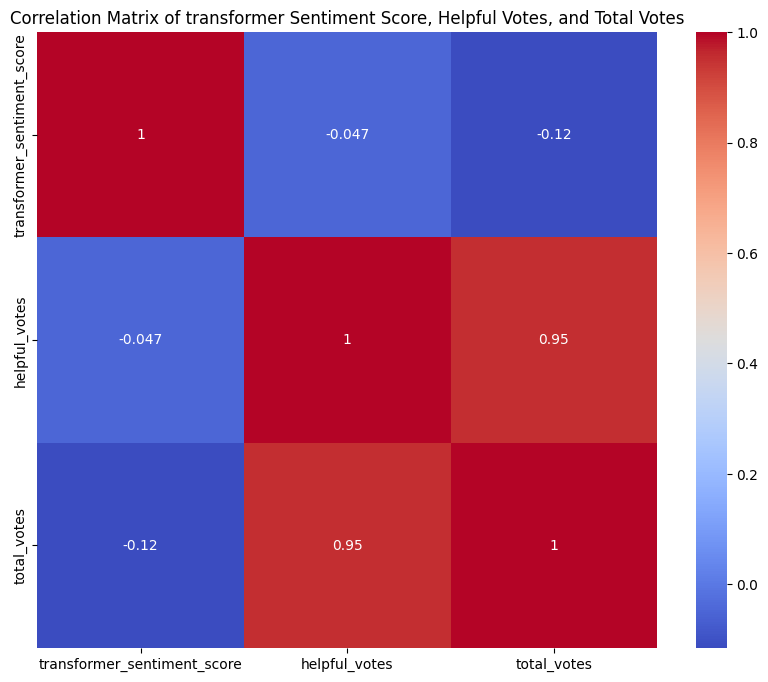

In [63]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of transformer Sentiment Score, Helpful Votes, and Total Votes')
plt.show()


C:\Users\mouli\Documents\BrightFlag\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


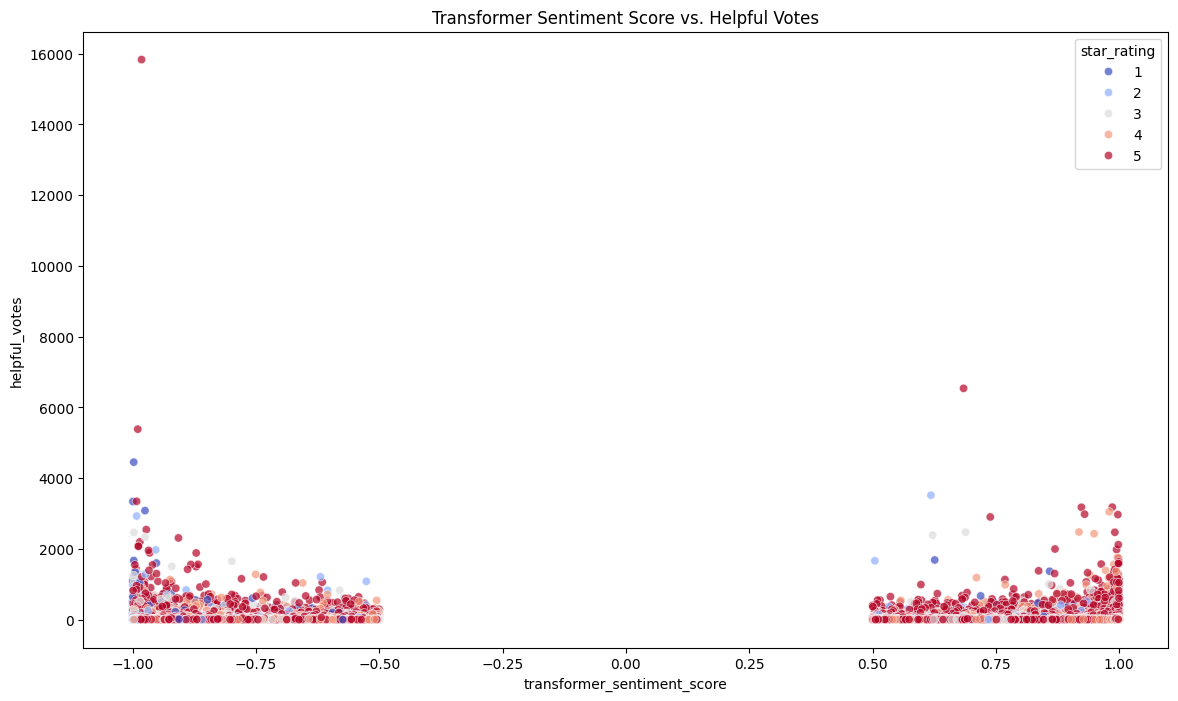

In [64]:
# Scatter plot to visualize the relationship
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_with_sentiment, x='transformer_sentiment_score', y='helpful_votes', hue='star_rating', palette='coolwarm', alpha=0.7)
plt.title('Transformer Sentiment Score vs. Helpful Votes')
plt.show()


C:\Users\mouli\Documents\BrightFlag\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


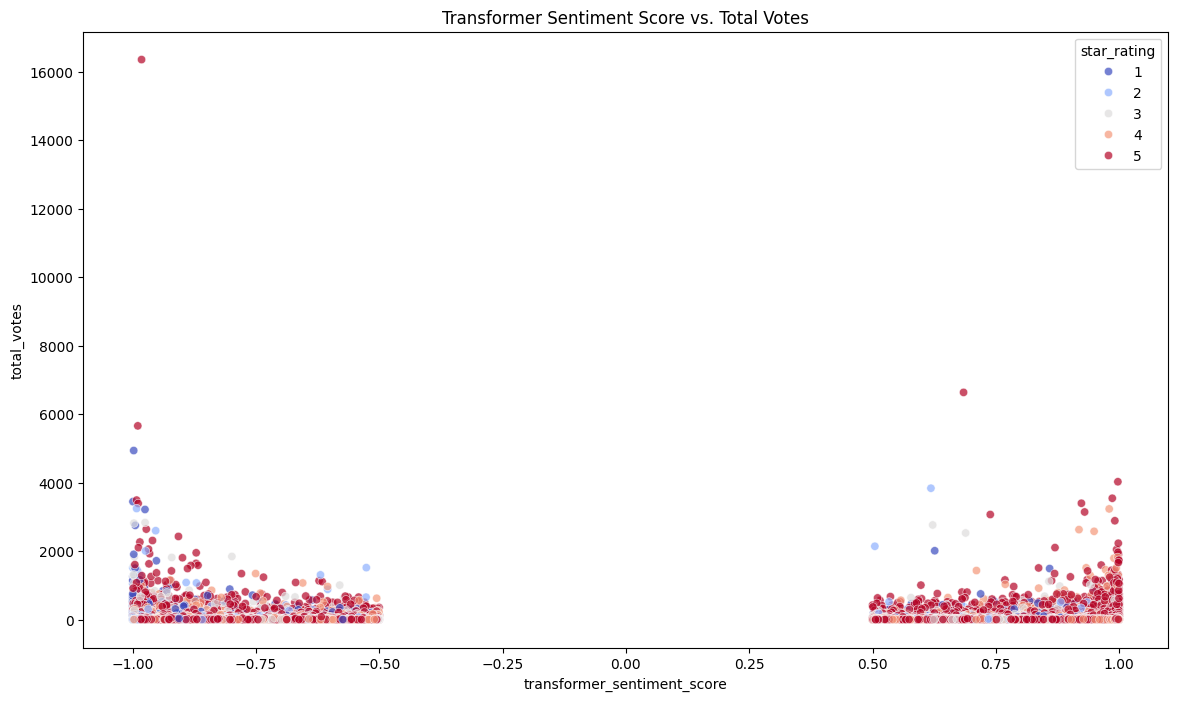

In [65]:

plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_with_sentiment, x='transformer_sentiment_score', y='total_votes', hue='star_rating', palette='coolwarm', alpha=0.7)
plt.title('Transformer Sentiment Score vs. Total Votes')
plt.show()

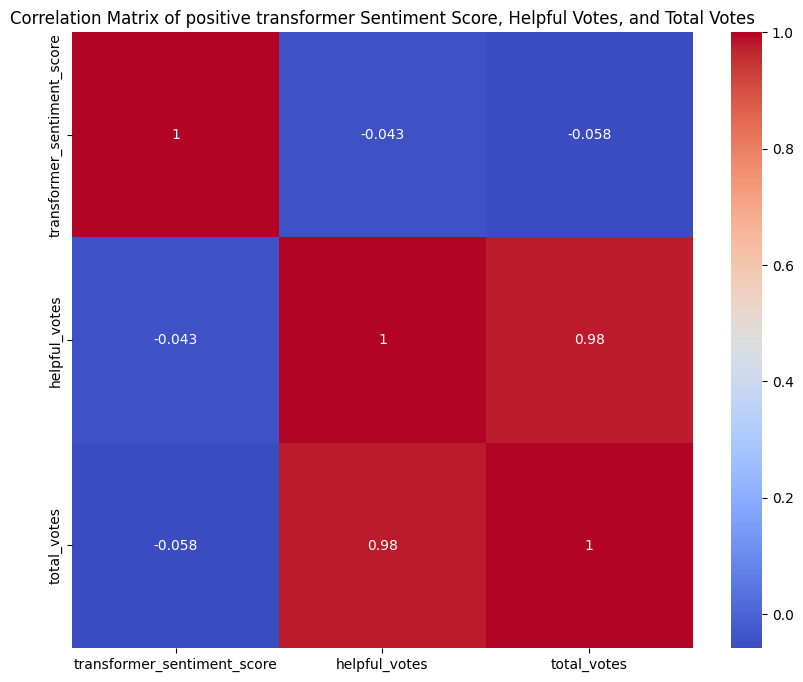

In [111]:
#  correlation of positive sentiment with helpful_votes and total_votes
correlation_matrix = df[df['transformer_sentiment_score']>0][['transformer_sentiment_score', 'helpful_votes', 'total_votes']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of positive transformer Sentiment Score, Helpful Votes, and Total Votes')
plt.show()


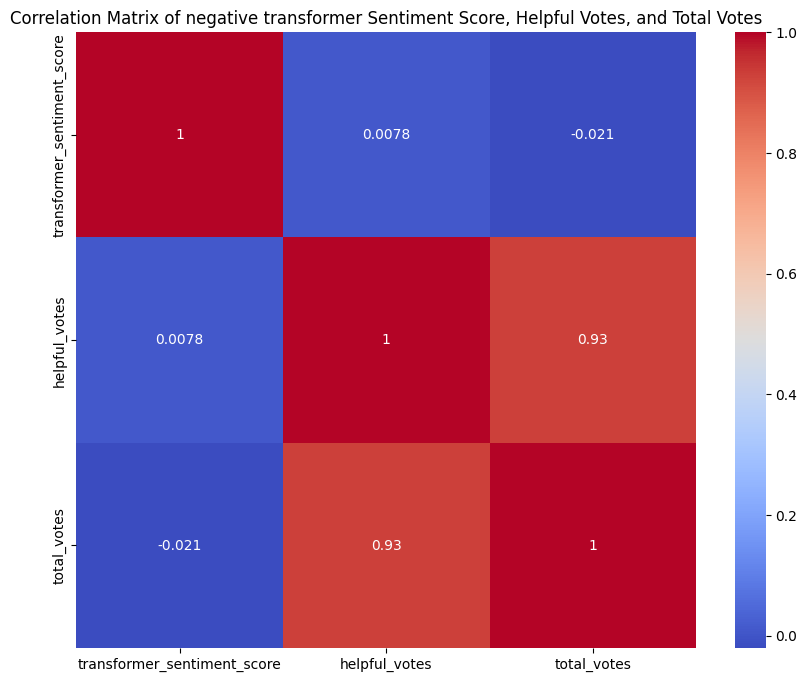

In [113]:
#  correlation of positive sentiment with helpful_votes and total_votes
correlation_matrix = df[df['transformer_sentiment_score']<=0][['transformer_sentiment_score', 'helpful_votes', 'total_votes']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of negative transformer Sentiment Score, Helpful Votes, and Total Votes')
plt.show()


# WordClouds

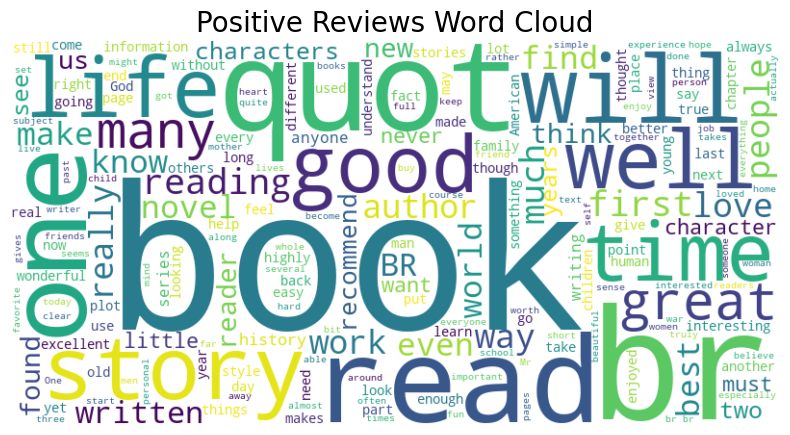

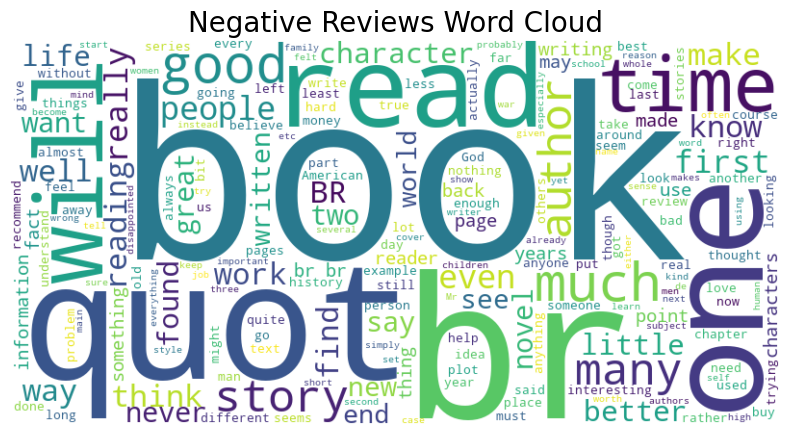

In [70]:
input_file = 'data/EDA/reviews_with_sentiment_transformer.csv'
chunk_size = 100000 

# Initialize word frequency dictionaries
positive_word_freq = {}
negative_word_freq = {}

"""
    This function updates word frequencies
"""
def update_word_frequencies(texts, word_freq):
    wordcloud = WordCloud()
    for text in texts:
        words = wordcloud.process_text(text)
        for word, count in words.items():
            if word in word_freq:
                word_freq[word] += count
            else:
                word_freq[word] = count

# Process the dataset in chunks
for chunk in pd.read_csv(input_file, chunksize=chunk_size):
    positive_texts = chunk[chunk['transformer_sentiment_score'] > 0]['review_body'].tolist()
    negative_texts = chunk[chunk['transformer_sentiment_score'] <= 0]['review_body'].tolist()
    
    update_word_frequencies(positive_texts, positive_word_freq)
    update_word_frequencies(negative_texts, negative_word_freq)

# Generate word clouds from the word frequency dictionaries
def generate_word_cloud_from_freq(word_freq, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Display word clouds
generate_word_cloud_from_freq(positive_word_freq, 'Positive Reviews Word Cloud')
generate_word_cloud_from_freq(negative_word_freq, 'Negative Reviews Word Cloud')

In [82]:
 (df['transformer_sentiment_score'] - df['sentiment_score']).abs()

0          0.059148
1          0.060444
2          1.397645
3          1.932536
4          0.076442
             ...   
3105361    1.986804
3105362    0.435870
3105363    0.067435
3105364    0.076420
3105365    0.336765
Length: 3105366, dtype: float64

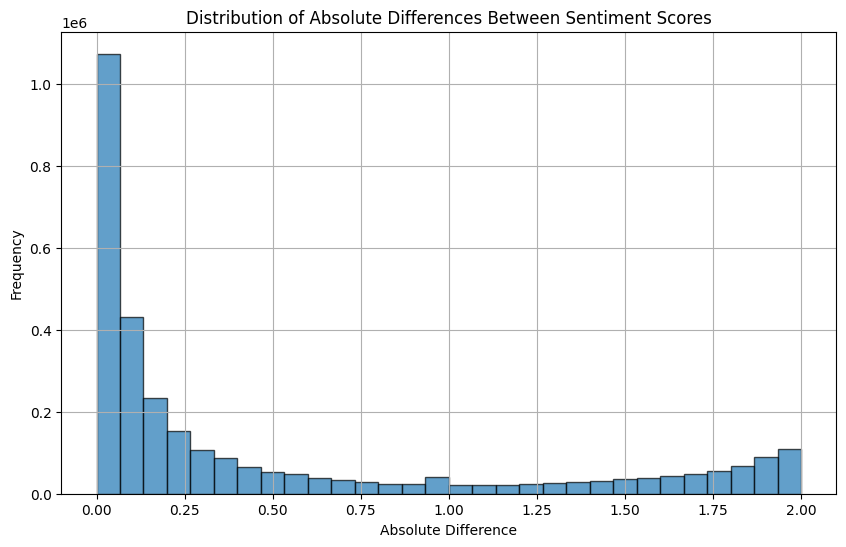

In [84]:
# Create a histogram
plt.figure(figsize=(10, 6))
plt.hist( (df['transformer_sentiment_score'] - df['sentiment_score']).abs(), bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Absolute Differences Between Sentiment Scores')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

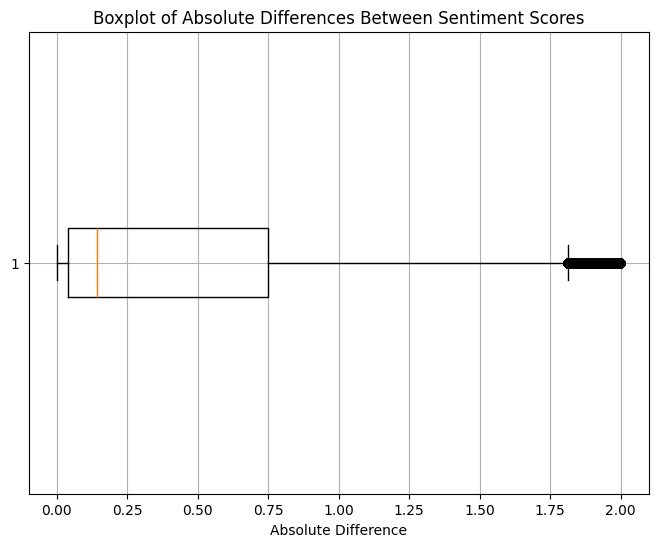

In [86]:
# Create a boxplot
plt.figure(figsize=(8, 6))
plt.boxplot((df['transformer_sentiment_score'] - df['sentiment_score']).abs(), vert=False)
plt.title('Boxplot of Absolute Differences Between Sentiment Scores')
plt.xlabel('Absolute Difference')
plt.grid(True)
plt.show()

      feature  correlation_with_votes
0          10                0.000460
1         100                0.003392
2         1st               -0.002299
3        2000                0.002253
4    absolute                0.002122
..        ...                     ...
995      year               -0.006599
996     years                0.003499
997       yes                0.006905
998     young               -0.011682
999      zero                0.012013

[1000 rows x 2 columns]


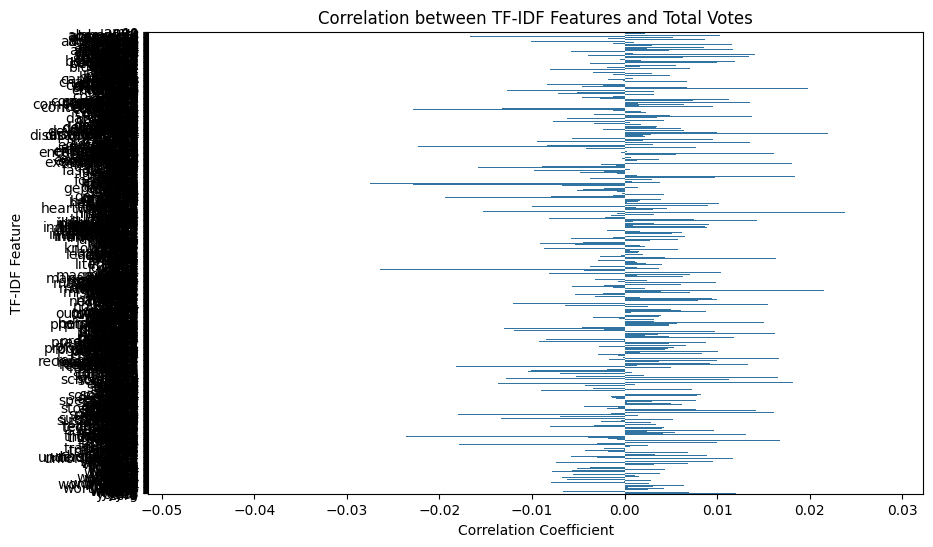

In [109]:

# Convert to Dask DataFrame
ddf = dd.from_pandas(df, npartitions=1)

# Handle NaN values in review_headline
ddf['review_headline'] = ddf['review_headline'].fillna('')

# Preprocess the text data
# Convert to lowercase
ddf['review_headline'] = ddf['review_headline'].str.lower()

# Compute TF-IDF on Dask DataFrame
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Compute TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(ddf['review_headline'].compute())

# Convert total_votes to a sparse matrix
total_votes = csr_matrix(ddf['total_votes'].compute().values.reshape(-1, 1))

# Initialize lists to store feature names and their correlations
features = tfidf_vectorizer.get_feature_names_out()
correlations = []

# Calculate correlation for each feature with total_votes
for i in range(tfidf_matrix.shape[1]):
    feature_column = tfidf_matrix[:, i].toarray().flatten()
    correlation, _ = spearmanr(feature_column, total_votes.toarray().flatten())
    correlations.append(correlation)

# Create a DataFrame for visualization
correlation_df = pd.DataFrame({
    'feature': features,
    'correlation_with_votes': correlations
})

# Display the correlations
print(correlation_df)

# Visualize the correlations
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_df['correlation_with_votes'], y=correlation_df['feature'])
plt.title('Correlation between TF-IDF Features and Total Votes')
plt.xlabel('Correlation Coefficient')
plt.ylabel('TF-IDF Feature')
plt.show()

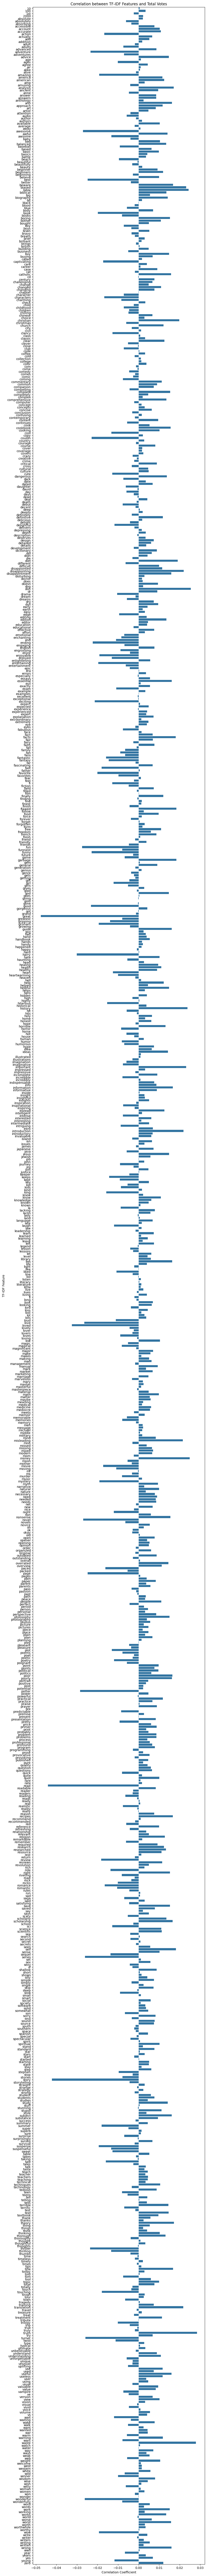

In [114]:
# Visualize the correlations
plt.figure(figsize=(10, 150))
sns.barplot(x=correlation_df['correlation_with_votes'], y=correlation_df['feature'])
plt.title('Correlation between TF-IDF Features and Total Votes')
plt.xlabel('Correlation Coefficient')
plt.ylabel('TF-IDF Feature')
plt.show()

      feature  correlation_with_helpful_votes
0          10                        0.001048
1         100                        0.002793
2         1st                       -0.001798
3        2000                        0.003153
4    absolute                        0.003210
..        ...                             ...
995      year                       -0.004280
996     years                        0.006038
997       yes                        0.005668
998     young                       -0.007934
999      zero                        0.007162

[1000 rows x 2 columns]


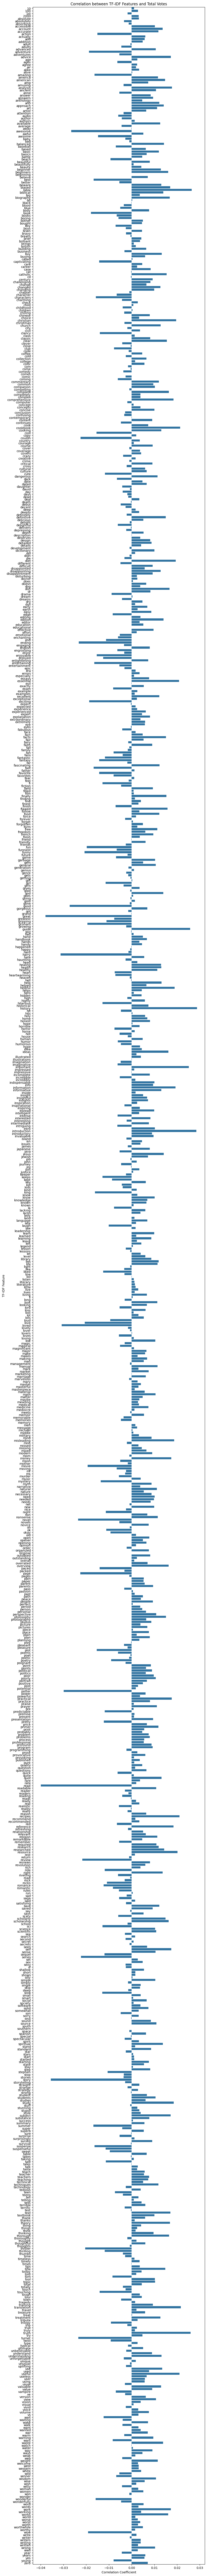

In [115]:

# Convert to Dask DataFrame
ddf = dd.from_pandas(df, npartitions=1)

# Handle NaN values in review_headline
ddf['review_headline'] = ddf['review_headline'].fillna('')

# Preprocess the text data
# Convert to lowercase
ddf['review_headline'] = ddf['review_headline'].str.lower()

# Compute TF-IDF on Dask DataFrame
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Compute TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(ddf['review_headline'].compute())

# Convert total_votes to a sparse matrix
helpful_votes = csr_matrix(ddf['helpful_votes'].compute().values.reshape(-1, 1))

# Initialize lists to store feature names and their correlations
features = tfidf_vectorizer.get_feature_names_out()
correlations = []

# Calculate correlation for each feature with total_votes
for i in range(tfidf_matrix.shape[1]):
    feature_column = tfidf_matrix[:, i].toarray().flatten()
    correlation, _ = spearmanr(feature_column, helpful_votes.toarray().flatten())
    correlations.append(correlation)

# Create a DataFrame for visualization
correlation_df = pd.DataFrame({
    'feature': features,
    'correlation_with_helpful_votes': correlations
})

# Display the correlations
print(correlation_df)

# Visualize the correlations
plt.figure(figsize=(10, 150))
sns.barplot(x=correlation_df['correlation_with_helpful_votes'], y=correlation_df['feature'])
plt.title('Correlation between TF-IDF Features and Total Votes')
plt.xlabel('Correlation Coefficient')
plt.ylabel('TF-IDF Feature')
plt.show()

# Data Preprocessing

In [21]:
df = pd.read_csv( 'data/EDA/reviews_with_sentiment_transformer.csv')

In [22]:
df.isna().sum()

review_date                    129
marketplace                      0
customer_id                      0
review_id                        0
product_id                       0
product_parent                   0
product_title                    0
product_category                 0
star_rating                      0
helpful_votes                    0
total_votes                      0
vine                             0
verified_purchase                0
review_headline                 53
review_body                      0
sentiment_score                  0
transformer_sentiment_score      0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105366 entries, 0 to 3105365
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   review_date                  object 
 1   marketplace                  object 
 2   customer_id                  int64  
 3   review_id                    object 
 4   product_id                   object 
 5   product_parent               int64  
 6   product_title                object 
 7   product_category             object 
 8   star_rating                  int64  
 9   helpful_votes                int64  
 10  total_votes                  int64  
 11  vine                         object 
 12  verified_purchase            object 
 13  review_headline              object 
 14  review_body                  object 
 15  sentiment_score              float64
 16  transformer_sentiment_score  float64
dtypes: float64(2), int64(5), object(10)
memory usage: 402.8+ MB


In [24]:
for name in df.columns:
    print(name,df[name].nunique())

review_date 3575
marketplace 1
customer_id 1502330
review_id 3105366
product_id 779710
product_parent 666016
product_title 713680
product_category 1
star_rating 5
helpful_votes 942
total_votes 1024
vine 2
verified_purchase 2
review_headline 2457126
review_body 3070632
sentiment_score 19984
transformer_sentiment_score 769315


In [25]:
df[df["vine"]=='Y']

review_date marketplace  customer_id       review_id  product_id  \
59094    2005-09-12          US     42321535  R2NKNL4WXWIWBG  1400062217   
1198593  2003-03-11          US     52254603   RAIG9ZQDMBF5P  0679742034   

         product_parent         product_title product_category  star_rating  \
59094         791531418  The Laments: A Novel            Books            4   
1198593       586032452      Buffalo Soldiers            Books            5   

         helpful_votes  total_votes vine verified_purchase  \
59094                3            3    Y                 Y   
1198593              3            6    Y                 N   

                   review_headline  \
59094    Doh! He *almost* made it!   
1198593            Brilliant Debut   

                                               review_body  sentiment_score  \
59094    There were times when I was so utterly charmed...           0.9079   
1198593  I pray that with the release of the film based...           0.9926   

         transformer_sentiment_score  
59094                      -0.985186  
1198593                     0.997914

In [26]:
# remove vine program reviews as they are only 2 reviews
df = df[df["vine"]=='N']

In [27]:
df['helpfulness_ratio'] = df.apply(lambda row: row['helpful_votes'] / row['total_votes'] if row['total_votes'] > 0 else 0, axis=1)

In [28]:
# combining review headline and review body to reduce feature complexity
df['review_text'] = df['review_headline'] + ' ' + df['review_body']
df = df.drop(columns=['review_body', 'review_headline'])

In [29]:
df['review_text'] = df['review_text'].astype(str)

In [30]:
df = df[['star_rating',  'transformer_sentiment_score', 'verified_purchase', 'vine', 'review_text','helpfulness_ratio']]

In [31]:
"""
    Due to computational limits of my personal system I am sampling only 20% of the original reviews
    I used stratify strategy for sampling
"""
df_sampled, _ = train_test_split(df, test_size=0.80, random_state=42, stratify=df[['star_rating']])
del df
del _

In [32]:
"""
    This function removes html tags
"""
def remove_html(text):
    return BeautifulSoup(text, "html.parser").get_text()

In [33]:
"""
    This function does 2 tasks.
        - Calls remove_html function to remove HTML tags
        - converts text into lover case and removes stop words
"""
def normalize_and_remove_stopwords(text):
    text = remove_html(text)
    return ' '.join([word for word in text.lower().split() if word.lower() not in stop_words])
df_sampled['review_text'] = df_sampled['review_text'].apply(normalize_and_remove_stopwords)

C:\Users\mouli\AppData\Local\Temp\ipykernel_10204\2229067044.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  return BeautifulSoup(text, "html.parser").get_text()


# Predict likelihood of a review being helpful

### Features and target variable
['star_rating', 'sentiment_score', 'transformer_sentiment_score', 'verified_purchase', 'vine', 'review_body']
These are the features selected for training random forest regression model

In [34]:
X = df_sampled[['star_rating', 'transformer_sentiment_score', 'verified_purchase', 'vine', 'review_text']]
y = df_sampled['helpfulness_ratio']
del df_sampled

In [35]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y

In [36]:
preprocessor = ColumnTransformer(
    transformers=[
        # ('num', StandardScaler(), ['star_rating', 'sentiment_score','transformer_sentiment_score']),
        ('cat', OneHotEncoder(), ['verified_purchase', 'vine']),
        ('text', TfidfVectorizer(analyzer='char', ngram_range=(1, 5), max_features=1000), 'review_text')
    ])

In [37]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42,verbose=2))],
                          verbose=True
                         )

In [38]:
model_pipeline.fit(X_train, y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=12.5min
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
bu

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 445.2min


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['verified_purchase',
                                                   'vine']),
                                                 ('text',
                                                  TfidfVectorizer(analyzer='char',
                                                                  max_features=1000,
                                                                  ngram_range=(1,
                                                                               5)),
                                                  'review_text')])),
                ('regressor',
                 RandomForestRegressor(random_state=42, verbose=2))],
         verbose=True)

In [39]:
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    4.6s


Mean Squared Error: 0.11537720445921854
R-squared: 0.10148913091736478


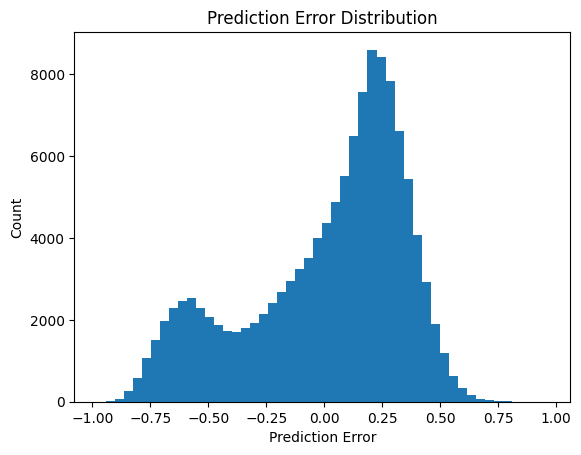

In [45]:
# Error Analysis
errors = y_test - y_pred
plt.hist(errors, bins=50)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.title('Prediction Error Distribution')
plt.show()